In [243]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# 评价指标
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False


In [244]:
train = pd.read_csv('/Users/yuhanli/Documents/Job Portfolio/Projects/1.阿里天池-金融风控-贷款风险预测 ing/dataset/train.csv')
test = pd.read_csv('/Users/yuhanli/Documents/Job Portfolio/Projects/1.阿里天池-金融风控-贷款风险预测 ing/dataset/testA.csv')

In [245]:
print(f"训练集: {train.shape[0]}条记录, {train.shape[1]}个特征")
print(f"测试集: {test.shape[0]}条记录, {test.shape[1]}个特征")

训练集: 800000条记录, 47个特征
测试集: 200000条记录, 46个特征


In [246]:
train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [247]:
#  样本个数和特征维度
train.shape
# (800000, 47)
test.shape
# (200000, 46)


(200000, 46)

In [248]:
train.columns


Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14'],
      dtype='object')

In [249]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [250]:
train.describe()
# train.describe().T

,id,loanAmnt,term,interestRate,installment,employmentTitle,homeOwnership,annualIncome,verificationStatus,isDefault,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,799999.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,...,759730.000000,759730.000000,759730.000000,759729.000000,759730.000000,766761.000000,730248.000000,759730.000000,759730.000000,759730.000000
mean,399999.500000,14416.818875,3.482745,13.238391,437.947723,72005.351714,0.614213,7.613391e+04,1.009683,0.199513,...,8.107937,8.575994,8.282953,14.622488,5.592345,11.643896,0.000815,0.003384,0.089366,2.178606
std,230940.252013,8716.086178,0.855832,4.765757,261.460393,106585.640204,0.675749,6.894751e+04,0.782716,0.399634,...,4.799210,7.400536,4.561689,8.124610,3.216184,5.484104,0.030075,0.062041,0.509069,1.844377
min,0.000000,500.000000,3.000000,5.310000,15.690000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199999.750000,8000.000000,3.000000,9.750000,248.450000,427.000000,0.000000,4.560000e+04,0.000000,0.000000,...,5.000000,4.000000,5.000000,9.000000,3.000000,8.000000,0.000000,0.000000,0.000000,1.000000
50%,399999.500000,12000.000000,3.000000,12.740000,375.135000,7755.000000,1.000000,6.500000e+04,1.000000,0.000000,...,7.000000,7.000000,7.000000,13.000000,5.000000,11.000000,0.000000,0.000000,0.000000,2.000000
75%,599999.250000,20000.000000,3.000000,15.990000,580.710000,117663.500000,1.000000,9.000000e+04,2.000000,0.000000,...,11.000000,11.000000,10.000000,19.000000,7.000000,14.000000,0.000000,0.000000,0.000000,3.000000
max,799999.000000,40000.000000,5.000000,30.990000,1715.420000,378351.000000,5.000000,1.099920e+07,2.000000,1.000000,...,70.000000,132.000000,79.000000,128.000000,45.000000,82.000000,4.000000,4.000000,39.000000,30.000000


In [251]:
# 数值类型
numerical_feature = list(train.select_dtypes(exclude=['object']).columns)
numerical_feature


['id',
 'loanAmnt',
 'term',
 'interestRate',
 'installment',
 'employmentTitle',
 'homeOwnership',
 'annualIncome',
 'verificationStatus',
 'isDefault',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'initialListStatus',
 'applicationType',
 'title',
 'policyCode',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'n13',
 'n14']

In [252]:
len(numerical_feature)  ## 42


42

In [253]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for fea in numerical_feature:
    temp = train[fea].nunique()# 返回的是唯一值的个数
    if temp == 1:
        unique_feature.append(fea)
     # 自定义变量的值的取值个数小于10就为离散型变量    
    elif temp <= 10:
        discrete_feature.append(fea)
    else:
        serial_feature.append(fea)


In [254]:
serial_feature

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'purpose',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'pubRecBankruptcies',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

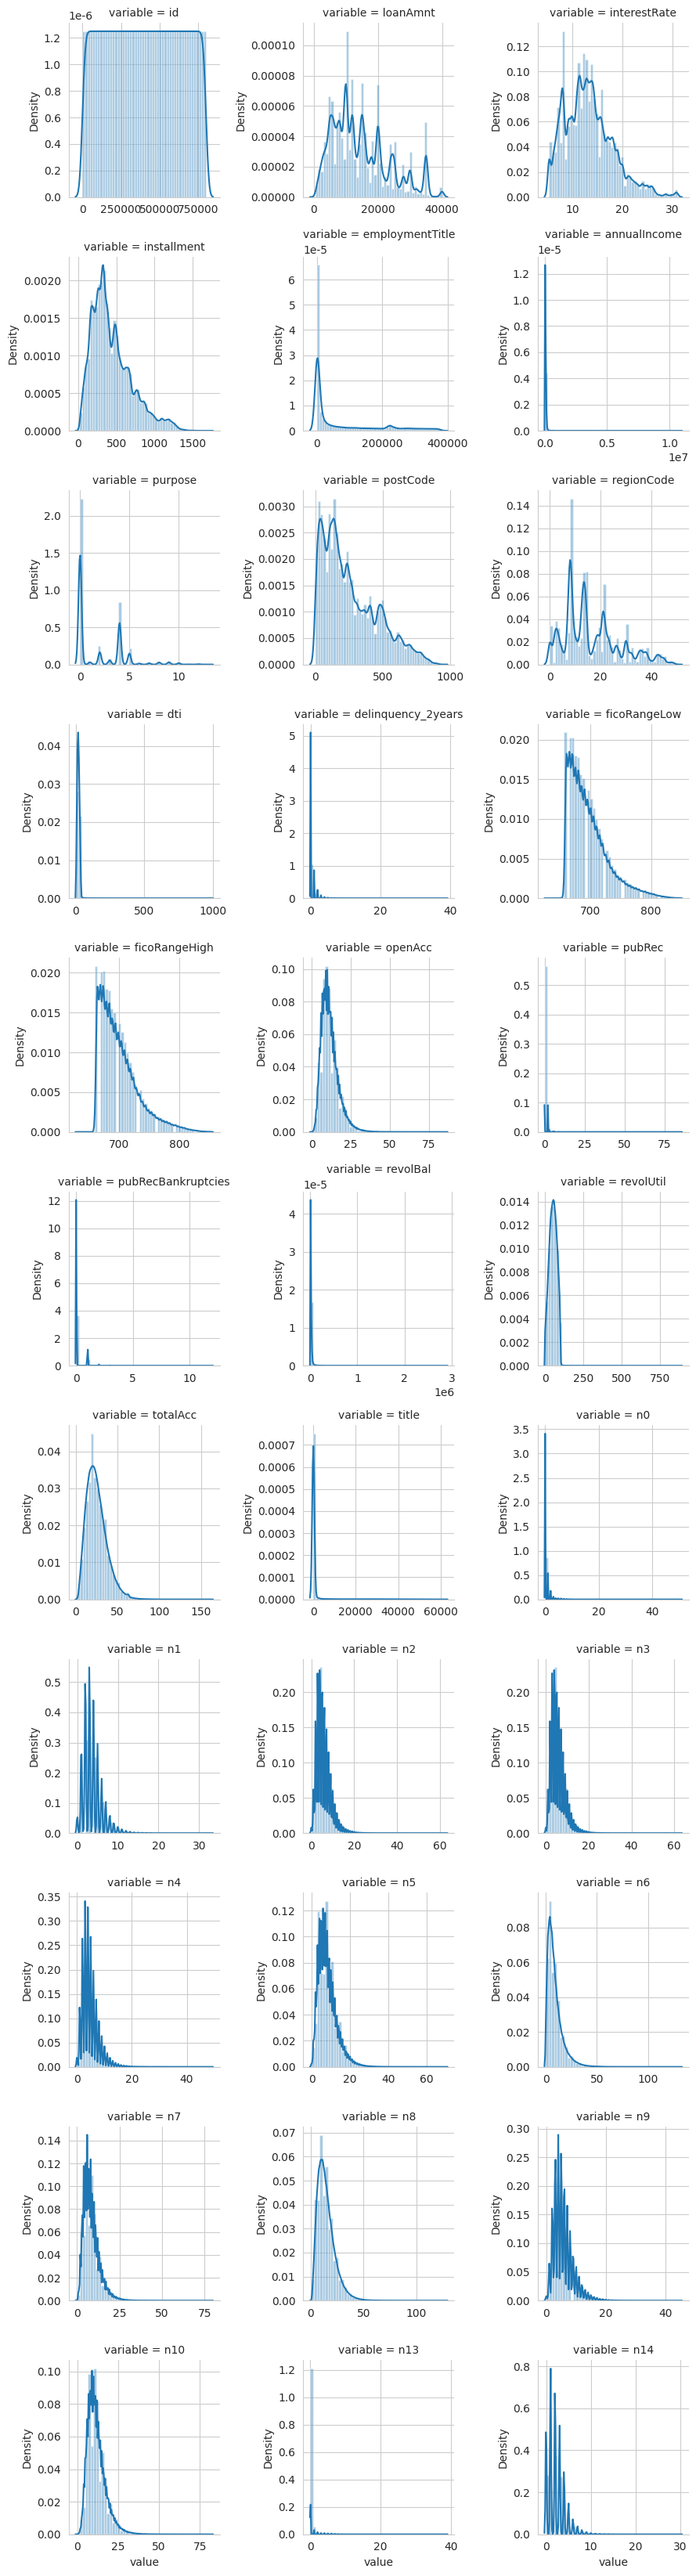

In [255]:
#每个数字特征得分布可视化
f = pd.melt(train, value_vars=serial_feature)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

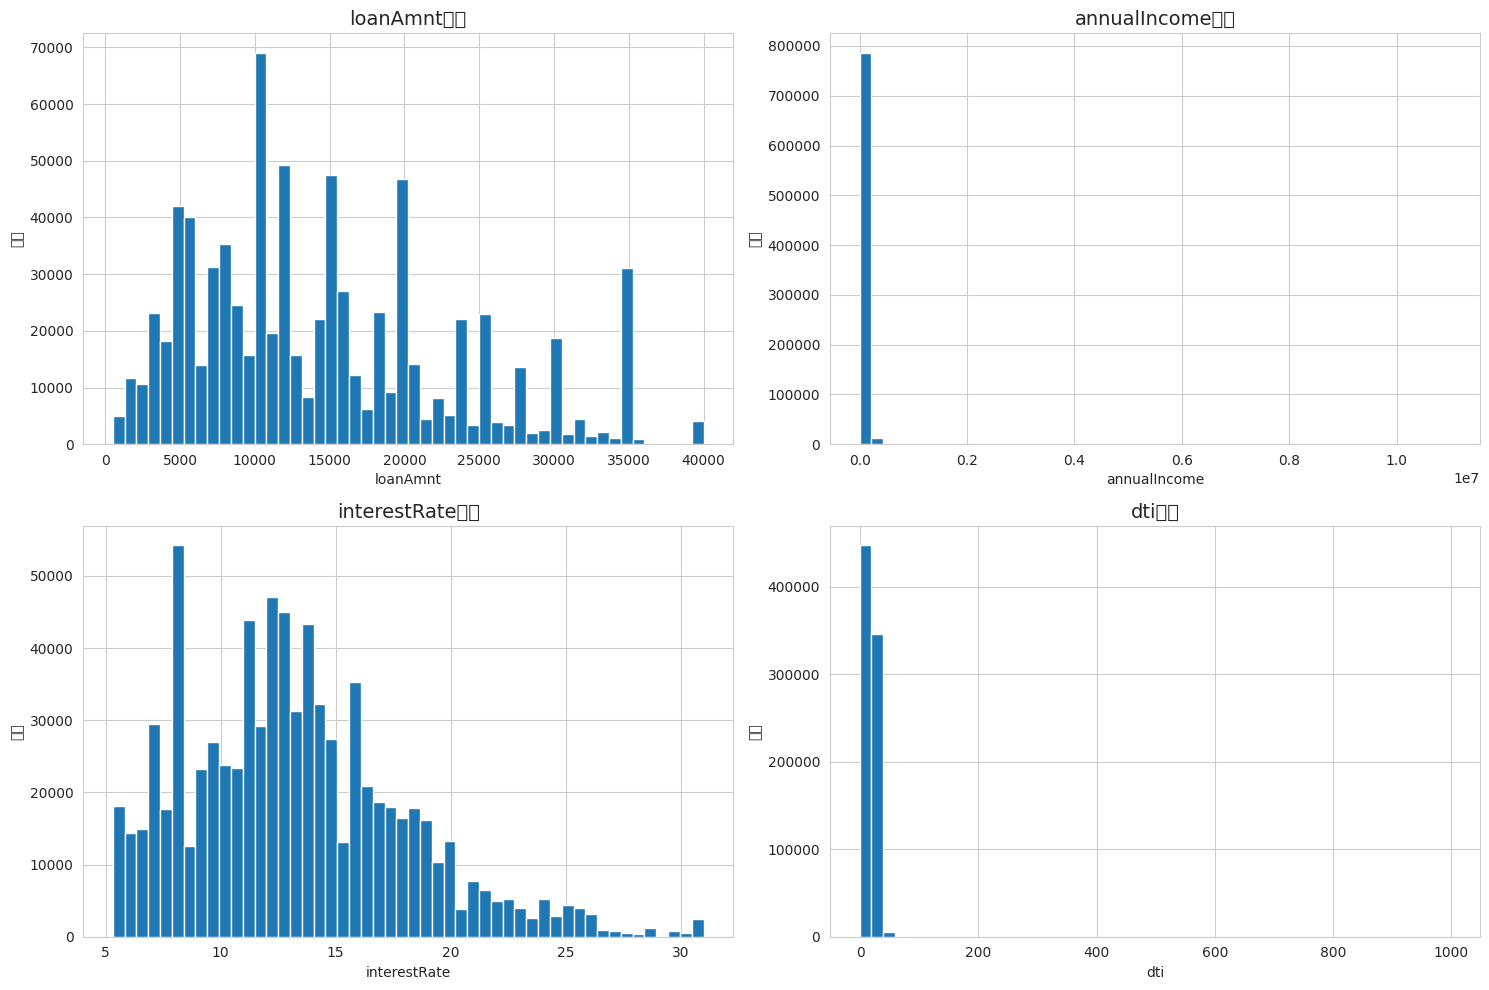

In [256]:
# 数值特征分布可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
num_features = ['loanAmnt', 'annualIncome', 'interestRate', 'dti']

for i, feat in enumerate(num_features):
    ax = axes[i//2, i%2]
    ax.hist(train[feat], bins=50)
    ax.set_title(f'{feat}分布', fontsize=14)
    ax.set_xlabel(feat)
    ax.set_ylabel('频数')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'loanAmnt')

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

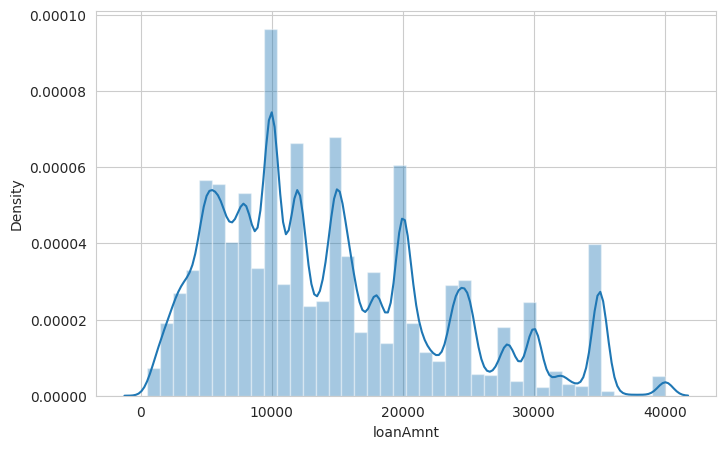

In [257]:
plt.figure(1 , figsize = (8 , 5))
sns.distplot(train.loanAmnt,bins=40)
plt.xlabel('loanAmnt')


In [258]:
discrete_feature

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [259]:
for f in discrete_feature:
    print(f, '类型数：', train[f].nunique())


term 类型数： 2
homeOwnership 类型数： 6
verificationStatus 类型数： 3
isDefault 类型数： 2
initialListStatus 类型数： 2
applicationType 类型数： 2
n11 类型数： 5
n12 类型数： 5


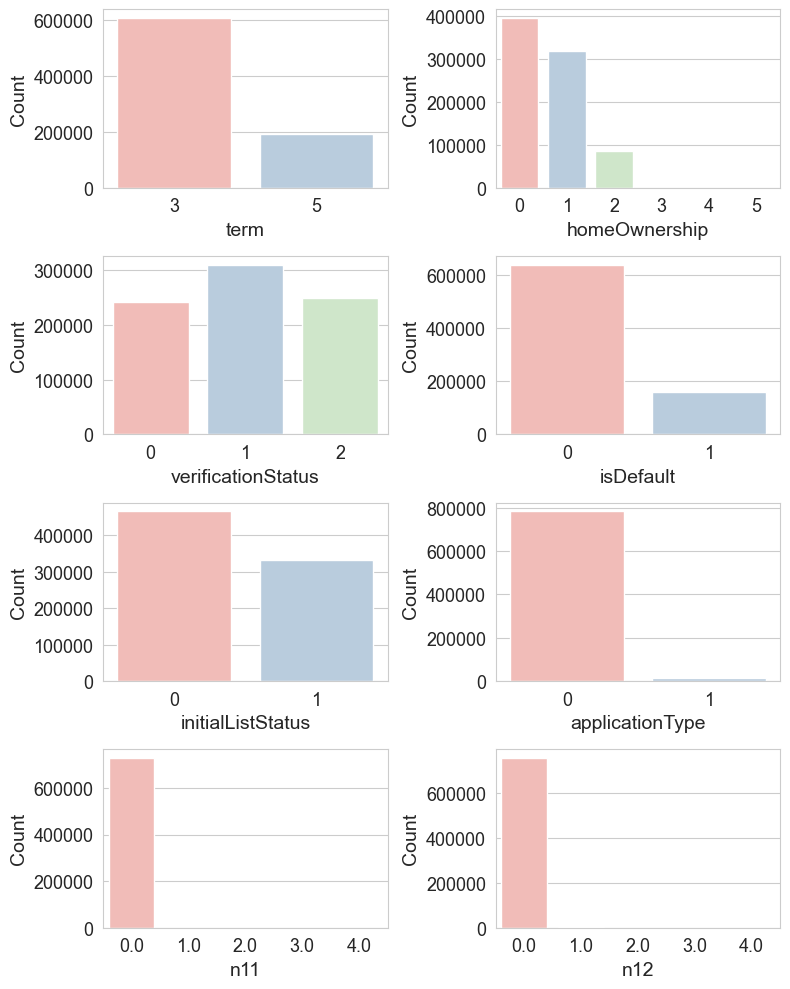

In [260]:
df_ = train[discrete_feature]

sns.set_style("whitegrid") # 使用whitegrid主题
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(8,10))
for i, item in enumerate(df_):
    plt.subplot(4,2,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(x = item,data = df_,palette="Pastel1")
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()

In [261]:
unique_feature

['policyCode']

In [262]:
# 分类型特征
category_feature = list(filter(lambda x: x not in numerical_feature,list(train.columns)))
category_feature

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [263]:
train[category_feature]

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002
799998,A,A4,10+ years,2015-02-01,Jan-1994


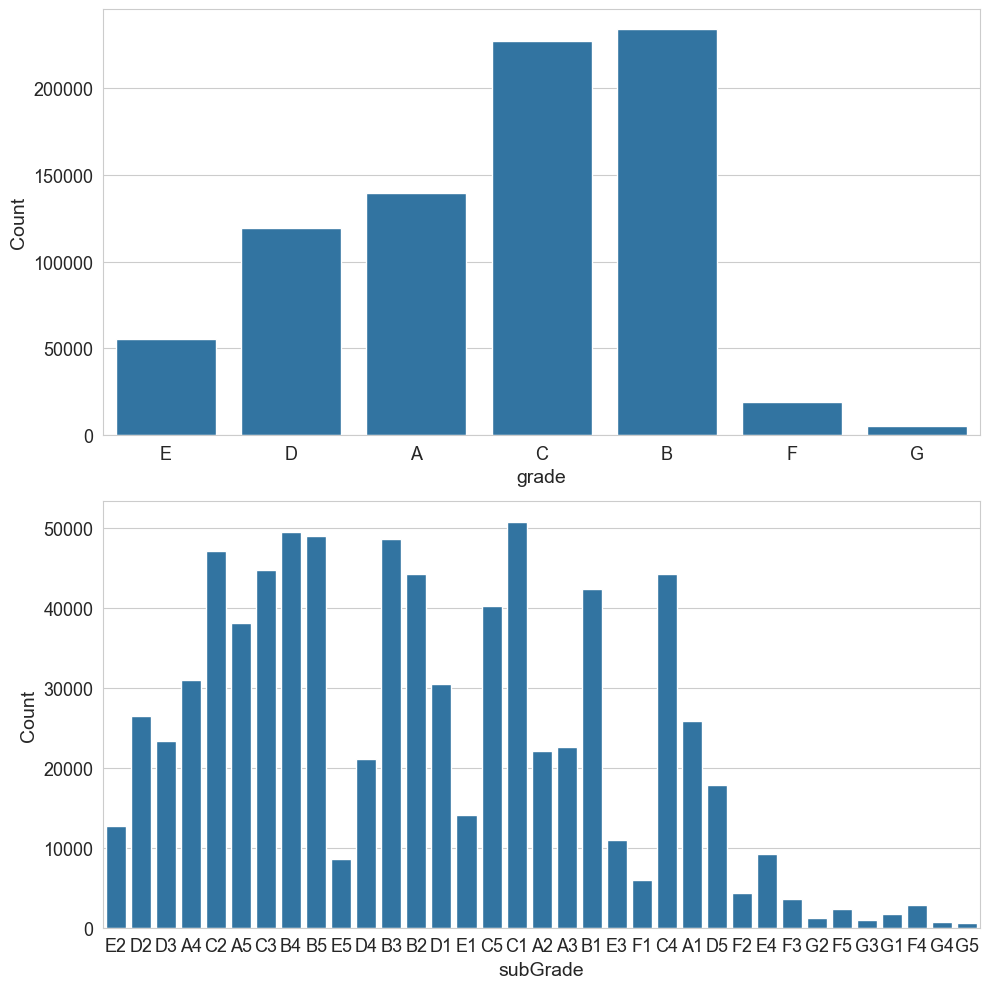

In [264]:
df_category = train[['grade', 'subGrade']]

sns.set_style("whitegrid") # 使用whitegrid主题
color = sns.color_palette()
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
for i, item in enumerate(df_category):
    plt.subplot(2,1,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(x = item,data = df_category)
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    #plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()


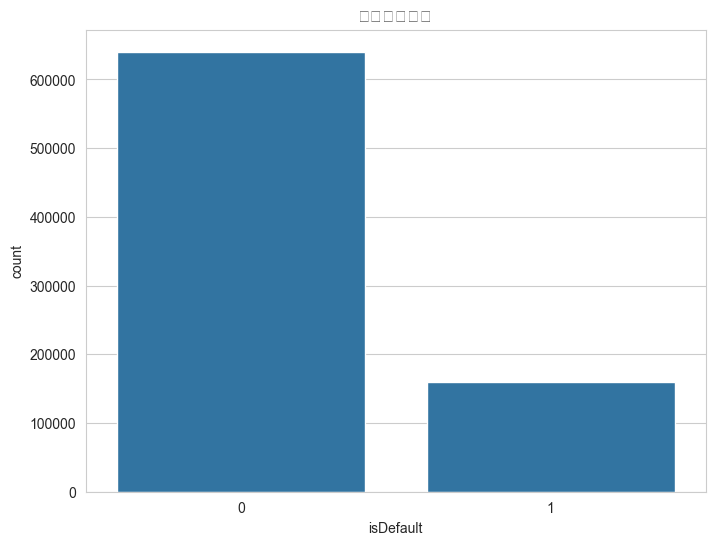

违约率: 19.95%


In [265]:
# 目标变量分布
plt.figure(figsize=(8,6))
sns.countplot(x='isDefault', data=train)
plt.title('违约比例分布')
plt.show()

print(f"违约率: {train['isDefault'].mean():.2%}")


In [266]:
# train_positve = train[train['isDefault'] == 1]
#train_negative = train[train['isDefault'] != 1]
#f, ax = plt.subplots(len(numerical_feature),2,figsize = (10,80))
#for i,col in enumerate(numerical_feature):
    #sns.distplot(train_positve[col],ax = ax[i,0],color = "blue")
    #ax[i,0].set_title("positive")
    #sns.distplot(train_negative[col],ax = ax[i,1],color = 'red')
    #ax[i,1].set_title("negative")
#plt.subplots_adjust(hspace = 1)


In [267]:
# 去掉标签
X_missing = train.drop(['isDefault'],axis=1)

# 查看缺失情况
missing = X_missing.isna().sum()
missing = pd.DataFrame(data={'特征': missing.index,'缺失值个数':missing.values})
#通过~取反，选取不包含数字0的行
missing = missing[~missing['缺失值个数'].isin([0])]
# 缺失比例
missing['缺失比例'] =  missing['缺失值个数']/X_missing.shape[0]
missing


,特征,缺失值个数,缺失比例
7,employmentTitle,1,0.000001
8,employmentLength,46799,0.058499
14,postCode,1,0.000001
16,dti,239,0.000299
22,pubRecBankruptcies,405,0.000506
24,revolUtil,531,0.000664
29,title,1,0.000001
31,n0,40270,0.050338
32,n1,40270,0.050338
33,n2,40270,0.050338


<Axes: >

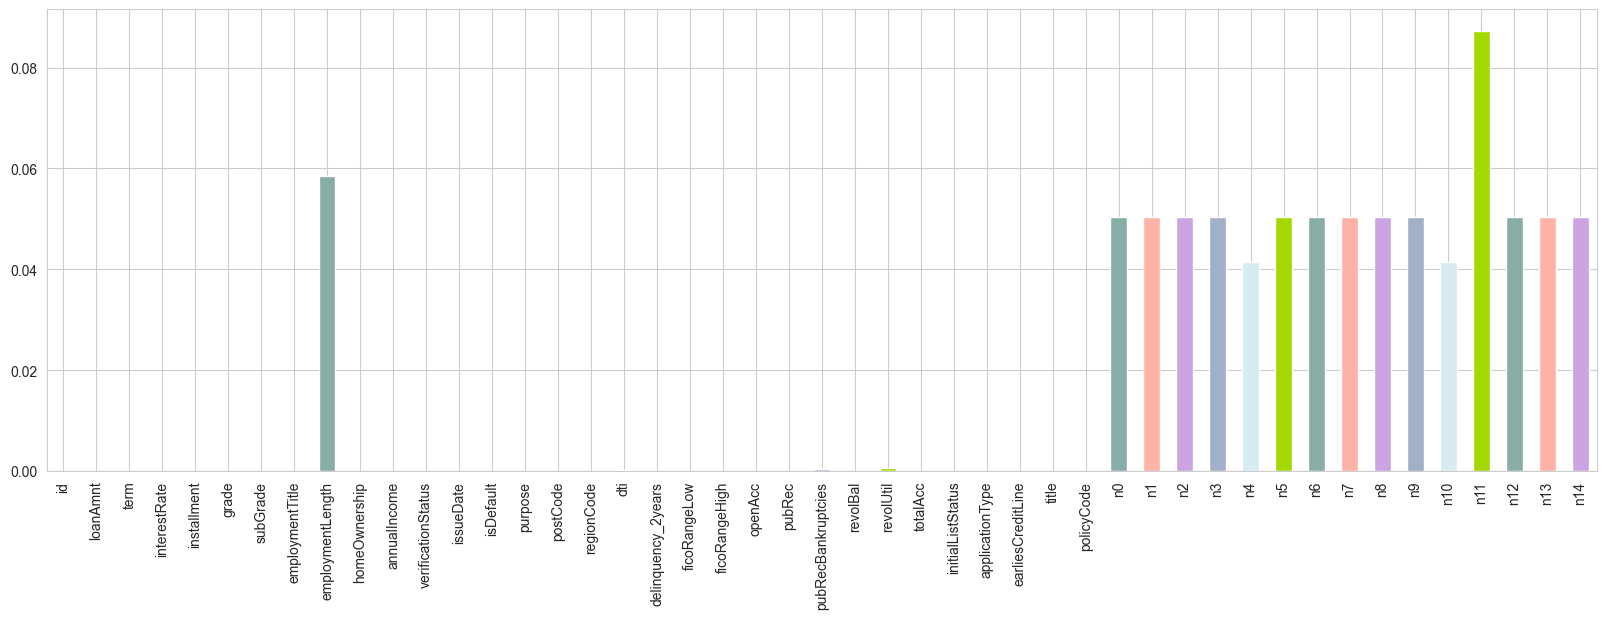

In [268]:
# 可视化
(train.isnull().sum()/len(train)).plot.bar(figsize = (20,6),color=['#d6ecf0','#a3d900','#88ada6','#ffb3a7','#cca4e3','#a1afc9'])

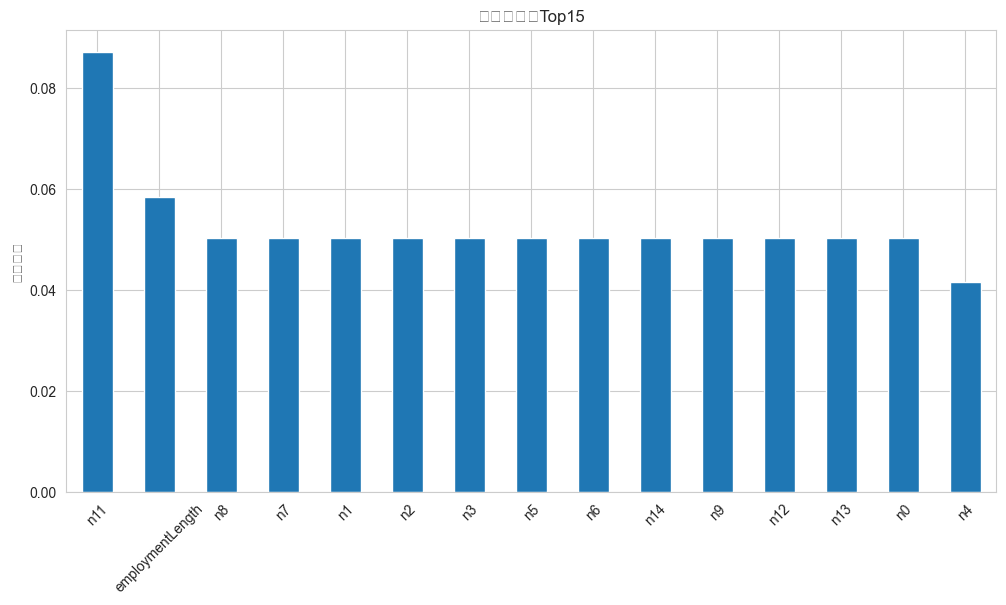

In [269]:
missing_rates = train.isnull().mean().sort_values(ascending=False)[:15]
plt.figure(figsize=(12, 6))
missing_rates.plot(kind='bar')
plt.title('特征缺失率Top15')
plt.ylabel('缺失比例')
plt.xticks(rotation=45)
plt.show()

<Axes: >

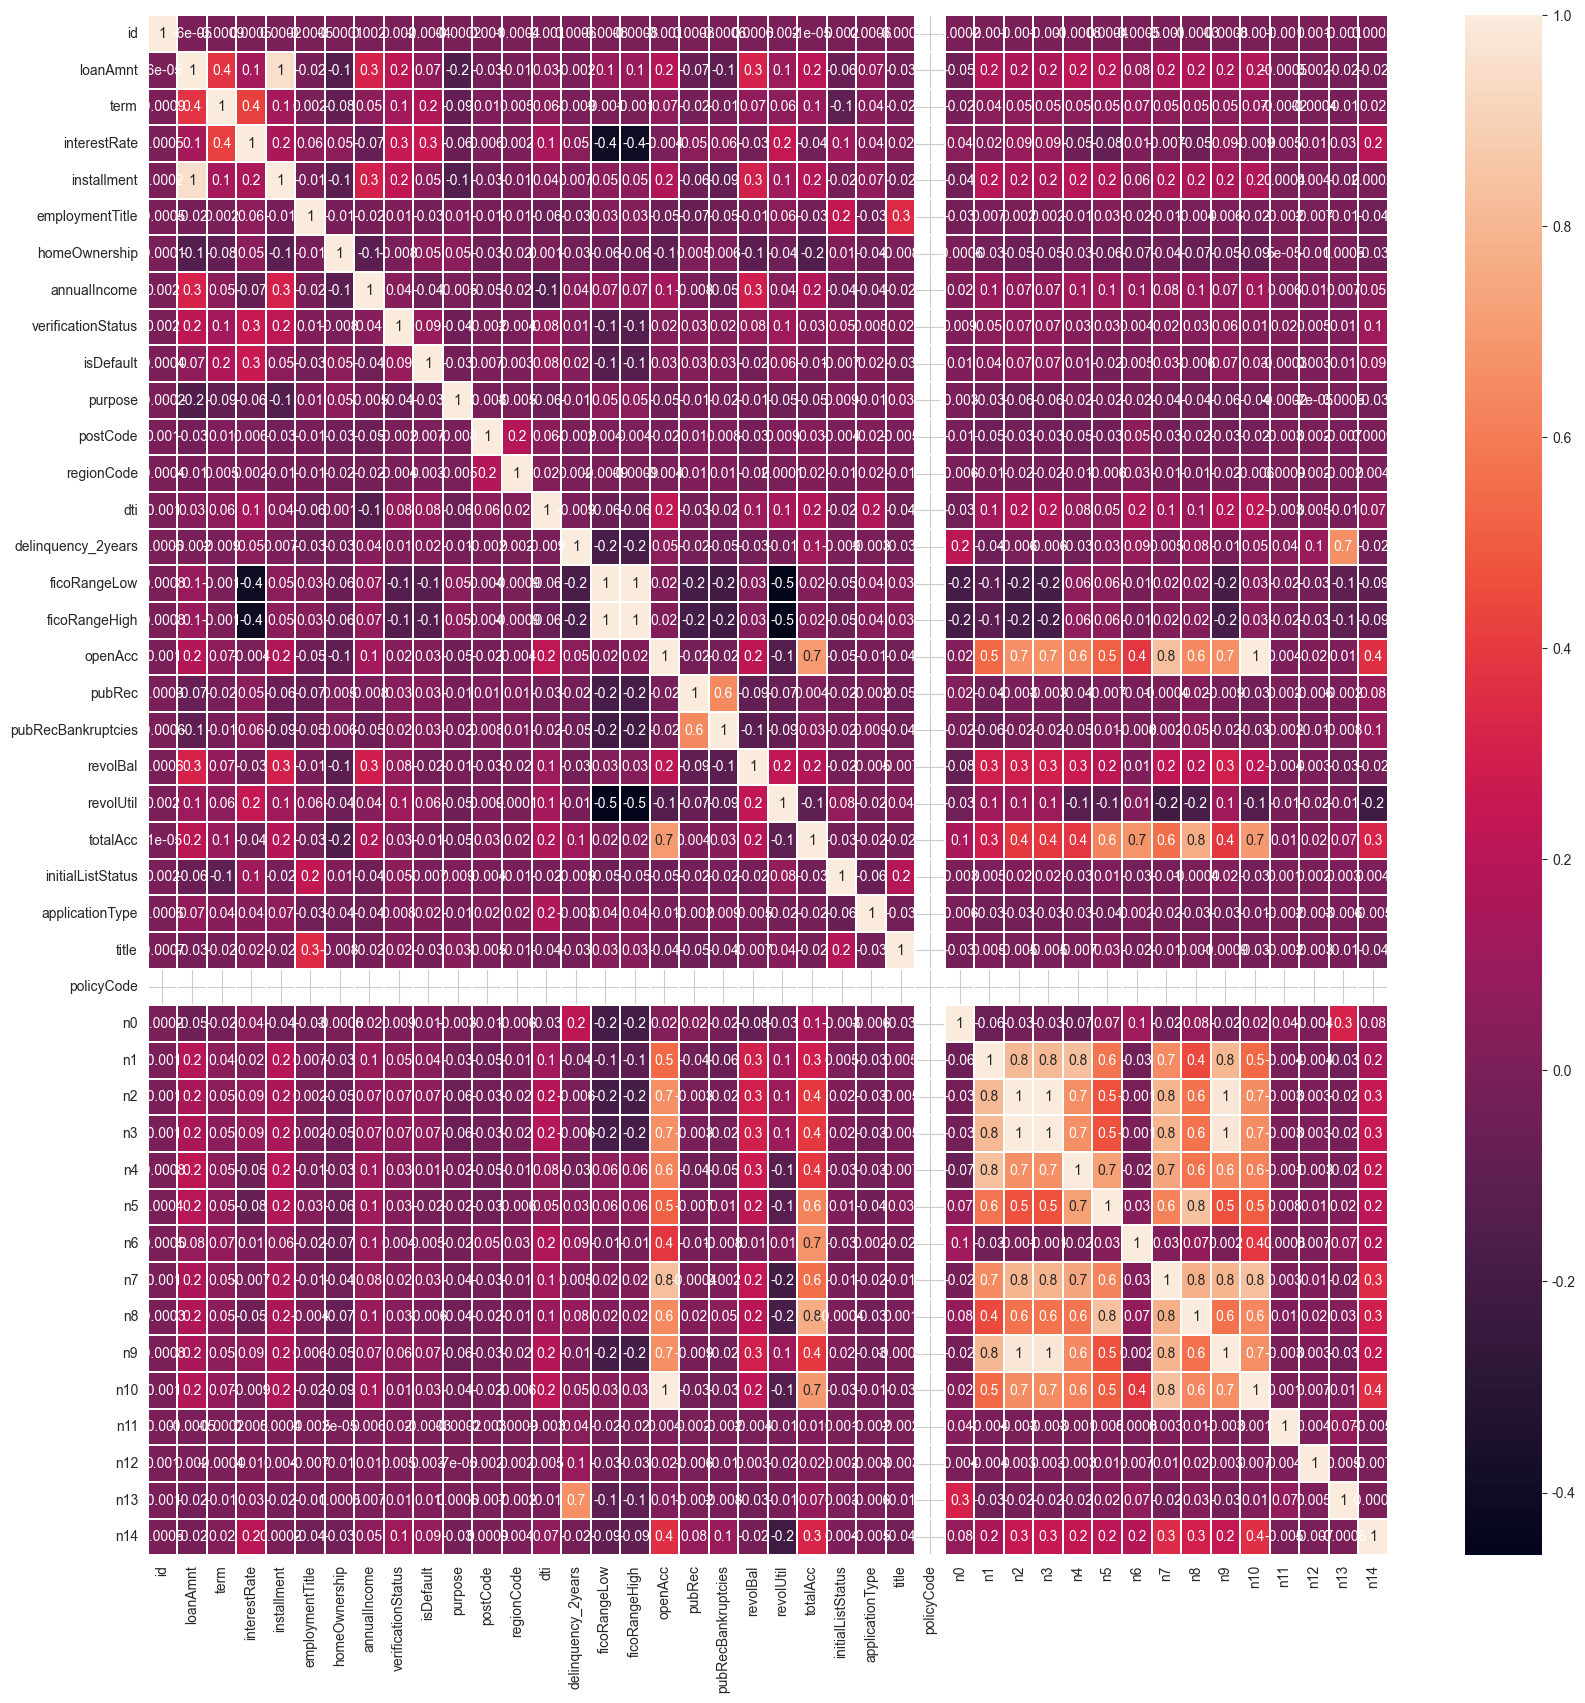

In [270]:
f, ax = plt.subplots(1,1, figsize = (20,20))
cor = train[numerical_feature].corr()
sns.heatmap(cor, annot = True, linewidth = 0.2, linecolor = "white", ax = ax, fmt =".1g" )

In [271]:
# 重复值
train.duplicated().sum()

np.int64(0)

In [272]:
# 缺失值处理
label = 'isDefault'
Y_label = train['isDefault']
numerical_feature.remove(label)


In [273]:
# 训练集
train[numerical_feature] = train[numerical_feature].fillna(train[numerical_feature].median())
# 测试集
test[numerical_feature] = test[numerical_feature].fillna(train[numerical_feature].median())

In [274]:
train[category_feature]

,grade,subGrade,employmentLength,issueDate,earliesCreditLine
0,E,E2,2 years,2014-07-01,Aug-2001
1,D,D2,5 years,2012-08-01,May-2002
2,D,D3,8 years,2015-10-01,May-2006
3,A,A4,10+ years,2015-08-01,May-1999
4,C,C2,NaN,2016-03-01,Aug-1977
...,...,...,...,...,...
799995,C,C4,7 years,2016-07-01,Aug-2011
799996,A,A4,10+ years,2013-04-01,May-1989
799997,C,C3,10+ years,2015-10-01,Jul-2002
799998,A,A4,10+ years,2015-02-01,Jan-1994


In [275]:
# 训练集
train[category_feature] = train[category_feature].fillna(train[category_feature].mode())
# 测试集
test[category_feature] = test[category_feature].fillna(train[category_feature].mode())


In [276]:
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [277]:
train.employmentLength  

0           2 years
1           5 years
2           8 years
3         10+ years
4               NaN
            ...    
799995      7 years
799996    10+ years
799997    10+ years
799998    10+ years
799999      5 years
Name: employmentLength, Length: 800000, dtype: object

In [278]:
from sklearn.tree import DecisionTreeClassifier

empLenNotNullInd = train.employmentLength.notnull() # 不是空的行，返回True
columns = ['postCode','regionCode','employmentTitle','annualIncome'] # 用四个特征来预测employmentLength
train_empLen_X  = train.loc[empLenNotNullInd,columns]
train_empLen_y = train.employmentLength[empLenNotNullInd]

DTC = DecisionTreeClassifier() # 实例化
DTC.fit(train_empLen_X ,train_empLen_y) # 训练
print(DTC.score(train_empLen_X ,train_empLen_y))

0.9809320486828881


In [279]:
train.isnull().any().sum()

np.int64(1)

In [280]:
train['employmentLength'].value_counts(dropna=False).sort_index()

employmentLength
1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: count, dtype: int64

In [281]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [282]:
data_train = train.copy()
for fea in numerical_feature:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

id_outliers
正常值    800000
Name: count, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
loanAmnt_outliers
正常值    800000
Name: count, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
term_outliers
正常值    800000
Name: count, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
interestRate_outliers
正常值    794259
异常值      5741
Name: count, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
installment_outliers
正常值    792046
异常值      7954
Name: count, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
employmentTitle_outliers
正常值    800000
Name: count, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
homeOwnership_outliers
正常值    799701
异常值       299
Name: count, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype

In [283]:
train['issueDate']

0         2014-07-01
1         2012-08-01
2         2015-10-01
3         2015-08-01
4         2016-03-01
             ...    
799995    2016-07-01
799996    2013-04-01
799997    2015-10-01
799998    2015-02-01
799999    2018-08-01
Name: issueDate, Length: 800000, dtype: object

In [284]:
train.shape # (800000, 47)


(800000, 47)

In [285]:
import datetime
# 转化成时间格式 issueDateDT特征表示数据日期离数据集中日期最早的日期（2007-06-01）的天数
train['issueDate'] = pd.to_datetime(train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
train['issueDateDT'] = train['issueDate'].apply(lambda x: x-startdate).dt.days

train.shape # (800000, 48)

(800000, 48)

In [286]:
train[['issueDate','issueDateDT']]

,issueDate,issueDateDT
0,2014-07-01,2587
1,2012-08-01,1888
2,2015-10-01,3044
3,2015-08-01,2983
4,2016-03-01,3196
...,...,...
799995,2016-07-01,3318
799996,2013-04-01,2131
799997,2015-10-01,3044
799998,2015-02-01,2802


In [287]:
#转化成时间格式
test['issueDate'] = pd.to_datetime(train['issueDate'],format='%Y-%m-%d')
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
test['issueDateDT'] = test['issueDate'].apply(lambda x: x-startdate).dt.days

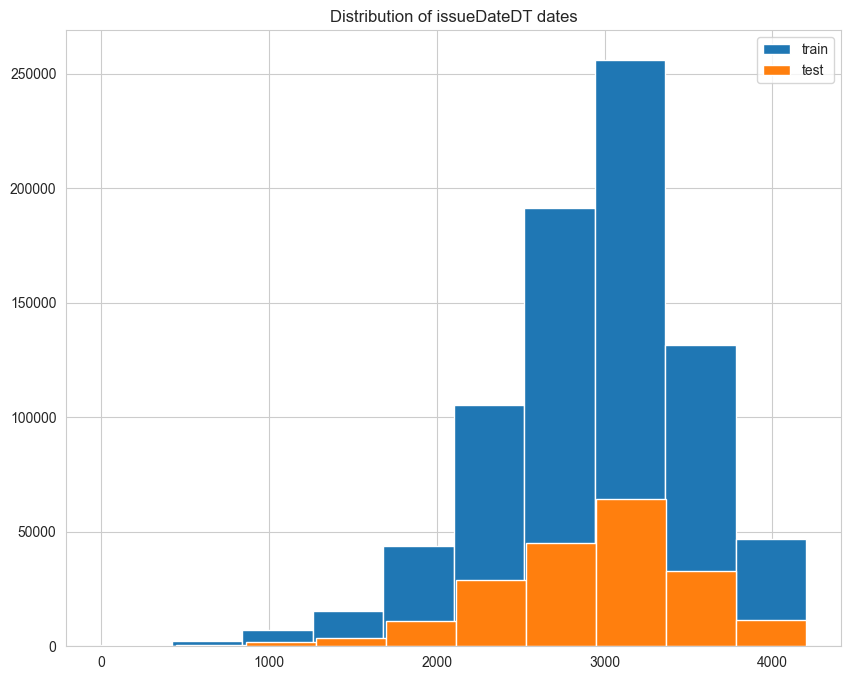

In [288]:
plt.figure(1 , figsize = (10 , 8))
plt.hist(train['issueDateDT'], label='train');
plt.hist(test['issueDateDT'], label='test');
plt.legend();
plt.title('Distribution of issueDateDT dates');
#train 和 test issueDateDT 日期有重叠 所以使用基于时间的分割进行验证是不明智的

In [289]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
train['loanAmnt_bin1'] = np.floor_divide(train['loanAmnt'], 1000)
## 通过对数函数映射到指数宽度分箱
train['loanAmnt_bin2'] = np.floor(np.log10(train['loanAmnt']))


In [290]:
train['loanAmnt_bin3'] = pd.qcut(train['loanAmnt'], 10, labels=False)


In [291]:
train[['issueDate','earliesCreditLine']]

,issueDate,earliesCreditLine
0,2014-07-01,Aug-2001
1,2012-08-01,May-2002
2,2015-10-01,May-2006
3,2015-08-01,May-1999
4,2016-03-01,Aug-1977
...,...,...
799995,2016-07-01,Aug-2011
799996,2013-04-01,May-1989
799997,2015-10-01,Jul-2002
799998,2015-02-01,Jan-1994


In [292]:
train_earliesCreditLine_year = train['earliesCreditLine'].apply(lambda x:x[-4:]).astype('int64')
test_earliesCreditLine_year = test['earliesCreditLine'].apply(lambda x:x[-4:]).astype('int64')

train_issueDate_year = train['issueDate'].astype('str').apply(lambda x:x[:4]).astype('int64')
test_issueDate_year = test['issueDate'].astype('str').apply(lambda x:x[:4]).astype('int64')

train['CreditLine'] = train_issueDate_year - train_earliesCreditLine_year
test['CreditLine'] = test_issueDate_year - test_earliesCreditLine_year

train = train.drop(['earliesCreditLine','issueDate'],axis=1)
test = test.drop(['earliesCreditLine','issueDate'],axis=1)

In [293]:
train['CreditLine']

0         13
1         10
2          9
3         16
4         39
          ..
799995     5
799996    24
799997    13
799998    21
799999    16
Name: CreditLine, Length: 800000, dtype: int64

In [294]:
train.shape ## (800000, 47)

(800000, 50)

In [295]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [train, test]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)


In [296]:
train['employmentLength'][:20]


0      2.0
1      5.0
2      8.0
3     10.0
4      NaN
5      7.0
6      9.0
7      1.0
8      5.0
9      NaN
10    10.0
11     3.0
12     2.0
13    10.0
14     2.0
15     2.0
16     9.0
17     0.0
18    10.0
19     9.0
Name: employmentLength, dtype: float64

In [297]:
train['employmentLength']



0          2.0
1          5.0
2          8.0
3         10.0
4          NaN
          ... 
799995     7.0
799996    10.0
799997    10.0
799998    10.0
799999     5.0
Name: employmentLength, Length: 800000, dtype: float64

In [298]:
a2z = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
a2z_code = np.arange(1,27)
a2z_mapping = dict(zip(a2z, a2z_code))

for data in [train,test]:
    data.loc[:,['grade','subGrade']] = data.loc[:,['grade','subGrade']].applymap(lambda g:g.replace(g[0], str(a2z.index(g[0])+1))).astype('int')


In [299]:
train[['grade','subGrade']]

,grade,subGrade
0,5,52
1,4,42
2,4,43
3,1,14
4,3,32
...,...,...
799995,3,34
799996,1,14
799997,3,33
799998,1,14


In [300]:
train[['grade','subGrade']]

,grade,subGrade
0,5,52
1,4,42
2,4,43
3,1,14
4,3,32
...,...,...
799995,3,34
799996,1,14
799997,3,33
799998,1,14


In [301]:
train[['homeOwnership','verificationStatus','purpose']]

,homeOwnership,verificationStatus,purpose
0,2,2,1
1,0,2,0
2,0,2,0
3,1,1,4
4,1,2,10
...,...,...,...
799995,1,0,0
799996,0,2,4
799997,1,2,0
799998,0,2,4


In [302]:
train.shape# (800000, 47)

(800000, 50)

In [303]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()  
oh.fit(train[['homeOwnership', 'verificationStatus', 'purpose']])
OneHot1 = oh.transform(train[['homeOwnership','verificationStatus','purpose']])
OneHot2 = oh.transform(test[['homeOwnership','verificationStatus','purpose']])

OneHot1.shape# (800000, 23)
'''
array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])
'''
train = pd.concat([train, pd.DataFrame(OneHot1)], axis=1)
test = pd.concat([test, pd.DataFrame(OneHot2)], axis=1)

train = train.drop(['homeOwnership','verificationStatus','purpose'],axis=1)
test = test.drop(['homeOwnership','verificationStatus','purpose'],axis=1)

train.shape# (800000, 67)

(800000, 48)

In [304]:
train=train.drop(["id"],axis=1) 
train.shape 

(800000, 47)

In [305]:
test=test.drop(["id"],axis=1) 
test.shape

(200000, 43)

In [306]:
train=train.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)
test=test.drop(["initialListStatus","n5","n11","n12","n8","postCode","policyCode"],axis=1)

train.shape# (800000, 59)


(800000, 40)

In [307]:
col = ['installment','ficoRangeHigh','openAcc','n3','n9']
for data in [train,test]:
    data.drop(col,axis=1,inplace=True)

In [308]:
col = ['applicationType']
for data in [train,test]:
    data.drop(col,axis=1,inplace=True)


In [309]:
X = train.drop(['isDefault'], axis=1)
y = train.loc[:,'isDefault']

kf = KFold(n_splits=5, shuffle=True, random_state=525)
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2)


In [310]:
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np

# Remove the sparse matrix column '0' if it exists
if '0' in X.columns:
    X = X.drop(['0'], axis=1)

cv_scores = []
for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train, y_train, X_val, y_val = X.iloc[train_index], y.iloc[train_index], X.iloc[val_index], y.iloc[val_index]
    
    # Convert object columns to numeric
    X_train = X_train.copy()
    X_val = X_val.copy()
    
    # Handle grade and subGrade columns if they are still object type
    if X_train['grade'].dtype == 'object':
        X_train['grade'] = X_train['grade'].astype('int64')
        X_val['grade'] = X_val['grade'].astype('int64')
    
    if X_train['subGrade'].dtype == 'object':
        X_train['subGrade'] = X_train['subGrade'].astype('int64')
        X_val['subGrade'] = X_val['subGrade'].astype('int64')
    # Convert object columns to numeric
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            # Check if it's a sparse matrix and convert to dense
            if hasattr(X_train[col].iloc[0], 'toarray'):
                X_train[col] = X_train[col].apply(lambda x: x.toarray().flatten()[0] if hasattr(x, 'toarray') else x)
                X_val[col] = X_val[col].apply(lambda x: x.toarray().flatten()[0] if hasattr(x, 'toarray') else x)
            else:
                X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
                X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    
    # Handle any NaN values created by coerce
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_train.mean())
    
    train_matrix = lgb.Dataset(X_train, label=y_train)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': 0.1,
        'metric': 'auc',
        'min_child_weight': 1e-3,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 525,
        'nthread': 8,
        'silent': True,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, callbacks=
                      [lgb.log_evaluation(period=1000), lgb.early_stopping(200)])
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_score_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))
 

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 127720, number of negative: 512280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2958
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 33
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199563 -> initscore=-1.389031
[LightGBM] [Info] Start training from score -1.389031
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[368]	valid_0's auc: 0.734538
[np.float64(0.7345378580784647)]
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 127735

The error occurs because LightGBM's `train()` function expects numeric data types (int, float, or bool), but your dataset contains `object` dtype columns (likely strings or mixed types).

**Root cause:** Column 0 (or other columns) has `object` dtype instead of numeric types.

**Solution:** Convert object columns to numeric types before training:





**Key steps:**
1. **Check dtypes**: `X_train.dtypes` to identify problematic columns
2. **Convert to numeric**: `pd.to_numeric()` with `errors='coerce'` converts non-numeric values to NaN
3. **Handle NaN**: Fill missing values with the column mean (or your preferred strategy)
4. **Verify**: Ensure all columns are int/float/bool before passing to LightGBM

This should resolve the ValueError.

The issue is that `verbose_eval` is not a valid parameter for `lgb.train()`. In LightGBM, you should use `callbacks` instead to control logging behavior.

Here's the corrected code:





**Key changes:**
- **`callbacks` parameter**: Replaces the old `verbose_eval` and `early_stopping_rounds` parameters
- **`lgb.log_evaluation(period=1000)`**: Logs evaluation metrics every 1000 rounds (equivalent to `verbose_eval=1000`)
- **`lgb.early_stopping(200)`**: Stops training if no improvement for 200 rounds (replaces `early_stopping_rounds=200`)

**Why this changed:** LightGBM updated its API to use a callback system, which is more flexible and modern. The old parameter names still exist in some older versions, but `callbacks` is the recommended approach for current versions.

If you're using an older LightGBM version, you could also try `early_stopping_rounds` as a separate parameter, but using callbacks is the best practice going forward.

AUC：0.7327271022740581


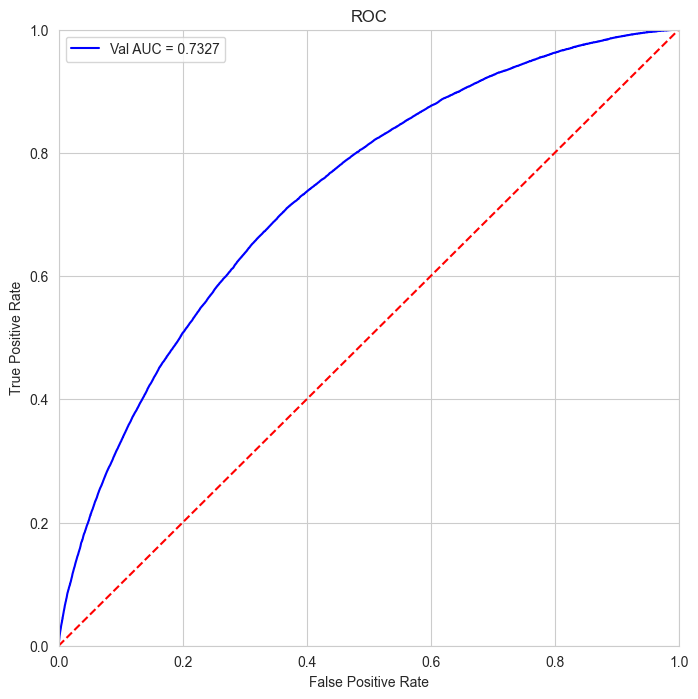

In [311]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

al_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC：{}'.format(roc_auc))

plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()


In [312]:
X = train.drop(['isDefault'], axis=1)
y = train.loc[:,'isDefault']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3)


In [313]:
import scipy.sparse as sp

X = train.drop(['isDefault'], axis=1)
y = train.loc[:,'isDefault']

# First, convert sparse matrix columns to dense
for col in X.columns:
    # Check if the column values are sparse matrices
    if len(X) > 0 and sp.issparse(X[col].iloc[0]):
        X[col] = X[col].apply(lambda x: x.toarray().flatten()[0] if sp.issparse(x) else x)

# Now convert object columns to numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any NaN values created by coerce
X = X.fillna(X.mean())

# Ensure all columns are numeric
X = X.astype('float32')

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3)

from xgboost.sklearn import XGBClassifier
clf1 = XGBClassifier(n_jobs=-1)
clf1.fit(Xtrain, Ytrain)
print(f"XGBoost Score: {clf1.score(Xtest, Ytest)}")


XGBoost Score: 0.8055208333333334


In [314]:
from sklearn.metrics import roc_curve, auc

predict_proba = clf1.predict_proba(Xtest)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytest, predict_proba[:,1])
auc(false_positive_rate, true_positive_rate)


np.float64(0.7312142434191502)

In [319]:
import scipy.sparse as sp

X = train.drop(['isDefault'], axis=1)
y = train.loc[:,'isDefault']

# First, convert sparse matrix columns to dense
for col in X.columns:
    # Check if the column values are sparse matrices
    if len(X) > 0 and sp.issparse(X[col].iloc[0]):
        X[col] = X[col].apply(lambda x: x.toarray().flatten()[0] if sp.issparse(x) else x)

# Now convert object columns to numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any NaN values created by coerce
X = X.fillna(X.mean())

# Ensure all columns are numeric
X = X.astype('float32')

# Convert all column names to strings (CRITICAL FIX)
X.columns = X.columns.astype(str)

# Now use X for cross-validation
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

gra = GradientBoostingClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()
models = [gra, xgb, lgb]
model_names = ["gra", "xgb", "lgb"]

# 交叉验证看看上述3个算法评分
for i, model in enumerate(models):
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy", n_jobs=-1)
    print(model_names[i], np.array(score).round(3), round(score.mean(), 3))

gra [0.806 0.804 0.805 0.804 0.805] 0.805
xgb [0.806 0.805 0.806 0.806 0.806] 0.806
[LightGBM] [Info] Number of positive: 127688, number of negative: 512312
[LightGBM] [Info] Number of positive: 127688, number of negative: 512312
[LightGBM] [Info] Number of positive: 127688, number of negative: 512312
[LightGBM] [Info] Number of positive: 127688, number of negative: 512312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2954
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199513 -> initscore=-1.389344
[LightGBM] [Info] Start training from score -1.389344
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061893 seconds.
You can set `force_row_wise=true